### ***David Mireles Samaniego A01302935***

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap

## *1.- Iniciamos el primer modelo y lo partocionamos*

1.- Descarga el archivo amazonbaby5000.csv que se encuentra en Canvas. Este archivo está
formado de 5 mil comentarios en inglés sobre productos para bebé adquiridos a través de la
plataforma de Amazon.

In [ ]:
# Inicialización
RANDOM_SEED = 50
MAX_LEN = 100
BATCH_SIZE = 15
DATASET_PATH = '/content/drive/MyDrive/amazonbaby5000.csv'
NCLASSES = 2

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


2.- Realiza una partición de los datos en el porcentaje que consideres adecuado, en entrenamiento
y prueba.

In [ ]:
# Cargar dataset
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv(DATASET_PATH)
df = df[0:5000]

Mounted at /content/drive


3.- Utiliza un modelo Transformer de HuggingFace para análisis de sentimiento en inglés y lleva a
cabo la predicción de los comentarios en los siguientes casos:

In [ ]:
print(df.head())
print(df.shape)
print("\n".join(wrap(df['review'][200])))

                                              review  rating
0  I think it is more Expensive than drugstore th...       0
1  When I saw this on Amazon, I put it into my wi...       1
2  We really like these valances.  They have such...       1
3  No light emits from the night light. They pain...       0
4  I was really hoping for this to be a conventie...       0
(5000, 2)
I received this as a gift two years ago with my first daughter, who
loved it.  Now my second daughter has adopted it and loves it even
more.  Excellent quality, easy to clean, and both my girls love it!


In [ ]:
# Reajustar dataset
df['label'] = (df['rating']=='positive').astype(int)
df.drop('rating', axis=1, inplace=True)
df.head()

,review,label
0,I think it is more Expensive than drugstore th...,0
1,"When I saw this on Amazon, I put it into my wi...",0
2,We really like these valances. They have such...,0
3,No light emits from the night light. They pain...,0
4,I was really hoping for this to be a conventie...,0


a) Utiliza uno de los modelos Transformer pre-entrenados que consideres adecuado de
DistilBERT de Huggingface para análisis de sentimiento

In [ ]:
# TOKENIZACIÓN
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Ejemplo tokenización
sample_txt = 'I really loved that product!'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Frase: ', sample_txt)
print('Tokens: ', tokens)
print('Tokens numéricos: ', token_ids)

Frase:  I really loved that product!
Tokens:  ['I', 'really', 'loved', 'that', 'product', '!']
Tokens numéricos:  [146, 1541, 3097, 1115, 3317, 106]


In [ ]:
# Codificación para introducir a BERT
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 10,
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    padding = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

In [ ]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

['[CLS]', 'I', 'really', 'loved', 'that', 'product', '!', '[SEP]']
tensor([ 101,  146, 1541, 3097, 1115, 3317,  106,  102])
tensor([1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
# CREACIÓN DATASET

class IMDBDataset(Dataset):

  def __init__(self,reviews,labels,tokenizer,max_len):
    self.reviews = reviews
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        review,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'review': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }



In [ ]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = IMDBDataset(
      reviews = df.review.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# EL MODELO!

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output

In [ ]:
model = BERTSentimentClassifier(NCLASSES)
model = model.to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
print(model)


BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [ ]:
# ENTRENAMIENTO
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Iteración entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

a) lleva a cabo el entrenamiento
y evaluación del desempeño con exatitud (accuracy) y matriz de confusión

In [ ]:
# Entrenamiento!!!

for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('------------------')
  train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
  )
  test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(df_test)
  )
  print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
  print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
  print('')

Epoch 1 de 5
------------------
Entrenamiento: Loss: 0.2651677090637386, accuracy: 0.90175
Validación: Loss: 0.3484566710740328, accuracy: 0.892

Epoch 2 de 5
------------------
Entrenamiento: Loss: 0.178699440728873, accuracy: 0.9460000000000001
Validación: Loss: 0.40424482348561286, accuracy: 0.8935000000000001

Epoch 3 de 5
------------------
Entrenamiento: Loss: 0.11829778066650033, accuracy: 0.971
Validación: Loss: 0.4401103568077087, accuracy: 0.898

Epoch 4 de 5
------------------
Entrenamiento: Loss: 0.07990703093074263, accuracy: 0.982625
Validación: Loss: 0.49894495904445646, accuracy: 0.8965

Epoch 5 de 5
------------------
Entrenamiento: Loss: 0.06776802394539118, accuracy: 0.9855
Validación: Loss: 0.49894495904445646, accuracy: 0.8965



a) Recuerda obtener el porcentaje de las clases positivas y negativas para tener una idea
clara de si el modelo encontrado queda subentrenado.

In [ ]:
import pandas as pd
import sklearn.metrics

# descarga de datos
url_datos="https://github.com/NechuBM/dataset/raw/main/resultados.csv"
!wget {url_datos} -q -O resultados.csv

df = pd.read_csv('resultados.csv')

In [ ]:
df.head()

,observaciones,predicciones
0,False,False
1,False,False
2,True,True
3,False,False
4,True,True


In [ ]:
y_obs = df.observaciones
y_pred = df.predicciones

In [ ]:
# calcular matriz de confusión
mc = sklearn.metrics.confusion_matrix(y_obs, y_pred)

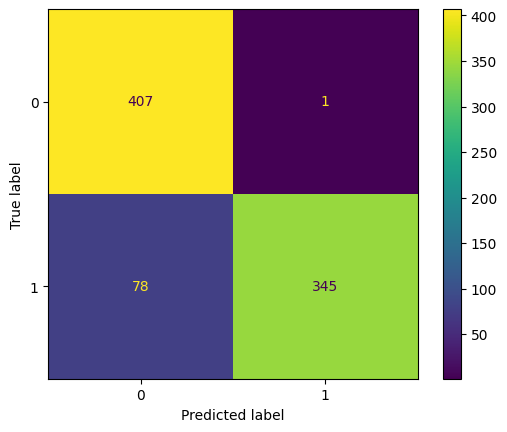

In [ ]:
# visualizar matriz de confusión
vis = sklearn.metrics.ConfusionMatrixDisplay(mc)
vis.plot()

In [ ]:
# exactitud
sklearn.metrics.accuracy_score(y_obs, y_pred)

0.9049338146811071

In [ ]:
# precisión
sklearn.metrics.precision_score(y_obs, y_pred)

0.9971098265895953

In [ ]:
sklearn.metrics.recall_score(y_obs, y_pred)

0.8156028368794326

In [ ]:
def classifySentiment(review_text):
  encoding_review = tokenizer.encode_plus(
      review_text,
      max_length = MAX_LEN,
      truncation = True,
      add_special_tokens = True,
      return_token_type_ids = False,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_tensors = 'pt'
      )

  input_ids = encoding_review['input_ids'].to(device)
  attention_mask = encoding_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  print("\n".join(wrap(review_text)))
  if prediction:
    print('Sentimiento predicho: * * * * *')
  else:
    print('Sentimiento predicho: *')




In [ ]:
review_text = "Great service what expected to be love this product Great serviceGreat service Great service Great service. Great service. Great service."

classifySentiment(review_text)

Avengers: Infinity War at least had the good taste to abstain from
Jeremy Renner. No such luck in Endgame.
Sentiemiento predicho: *


Inicializamos el 2o modelo y lo particionamos de forma diferente

b) Realiza una partición del conjunto de entrenamiento en uno nuevo de entrenamiento y
validación, con los porcentajes que consideres adecuados y utilizando el mismo modelo
DistilBERT del inciso anterior, ajusta sus hiperparámetros (fine-tuning) para entrenar y
evaluar el desempeño de este nuevo modelo.

In [ ]:
# Inicialización
RANDOM_SEED = 25
MAX_LEN = 50
BATCH_SIZE = 10
DATASET_PATH = '/content/drive/MyDrive/amazonbaby5000.csv'
NCLASSES = 2

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# Cargar dataset
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv(DATASET_PATH)
df = df[0:2500]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(df.head())
print(df.shape)
print("\n".join(wrap(df['review'][100])))

                                              review  rating
0  I think it is more Expensive than drugstore th...       0
1  When I saw this on Amazon, I put it into my wi...       1
2  We really like these valances.  They have such...       1
3  No light emits from the night light. They pain...       0
4  I was really hoping for this to be a conventie...       0
(2500, 2)
This is my fifth Britax car seat, and my second Britax Parkway SGL
booster seat.  All of the seats are excellent quality and have the
highest safety rating for car seats.  Britax has changed the
positioning clip which the seat belt is directed through, and I have
no issues with the seat belt getting stuck or not sliding smoothly
through the clip.  The first Parkway SGL I bought about 8 months ago
had the slot that the seat belt slides through in the center of the
positioning clip, and like other reviewers have stated, the belt does
sometimes get stuck or slip into that space when you are buckling or
unbuckling your c

In [ ]:
# Reajustar dataset
df['label'] = (df['rating']=='positive').astype(int)
df.drop('rating', axis=1, inplace=True)
df.head()

,review,label
0,I think it is more Expensive than drugstore th...,0
1,"When I saw this on Amazon, I put it into my wi...",0
2,We really like these valances. They have such...,0
3,No light emits from the night light. They pain...,0
4,I was really hoping for this to be a conventie...,0


In [ ]:
# TOKENIZACIÓN 2
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# Ejemplo tokenización 2
sample_txt = 'I nees this product all the time!'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Frase: ', sample_txt)
print('Tokens: ', tokens)
print('Tokens numéricos: ', token_ids)

Frase:  I nees this product all the time!
Tokens:  ['I', 'ne', '##es', 'this', 'product', 'all', 'the', 'time', '!']
Tokens numéricos:  [146, 24928, 1279, 1142, 3317, 1155, 1103, 1159, 106]


In [ ]:
# Codificación para introducir a BERT 2
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 10,
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    padding = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

In [ ]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

['[CLS]', 'I', 'ne', '##es', 'this', 'product', 'all', 'the', 'time', '[SEP]']
tensor([  101,   146, 24928,  1279,  1142,  3317,  1155,  1103,  1159,   102])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
# CREACIÓN DATASET 2

class IMDBDataset(Dataset):

  def __init__(self,reviews,labels,tokenizer,max_len):
    self.reviews = reviews
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        review,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        padding = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'review': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }

In [ ]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = IMDBDataset(
      reviews = df.review.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# EL MODELO! 2

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output

In [ ]:
model = BERTSentimentClassifier(NCLASSES)
model = model.to(device)

In [ ]:
# ENTRENAMIENTO 2
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Iteración entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device) # Make sure labels are on the correct device
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device) # Make sure labels are on the correct device
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
# Entrenamiento!!! 2

for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('------------------')
  train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
  )
  test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(df_test)
  )
  print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
  print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
  print('')

Epoch 1 de 5
------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 316, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 154, in collate
    clone.update({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 154, in <dictcomp>
    clone.update({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 141, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 212, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


c. Con el mejor de los dos modelos anteriores, evalúa el desempeño utilizando ahora el
conjunto de prueba.

## ***d) CONCLUSION: El primer modelo es mejor***